In [1]:
import numpy as np
import torch
import torch.nn as nn
import models.capsule_argmax
import torchvision
from torchvision import transforms, datasets
from torch.distributions import normal
import matplotlib.pyplot as plt
import captum
from captum.attr import DeepLift, IntegratedGradients, Saliency, NoiseTunnel, GradientShap
from captum.attr import visualization as viz
import argparse
from utils import get_args
import matplotlib

/home/bhui/miniconda3/envs/xy_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.set_device(1)

In [3]:
def add_gaussian_noise(noise_scale, input):
    noise = torch.randn_like(input) * noise_scale
    return input + noise

def predict_with_randomized_smoothing(noise_scale, model, image, num_samples):
    # Expand the single image to a batch
    image_batch = image.repeat(num_samples, 1, 1, 1)
    # Add Gaussian noise
    noisy_images = add_gaussian_noise(noise_scale, image_batch)

    # Predict using the model
    predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model(noisy_images)

    # Get the predicted classes for each noisy image
    _, predicted_classes = predictions.max(1)
    #Result
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    prediction = torch.bincount(predicted_classes).argmax().item()
    # Return the most frequently predicted class
    return avg_noisy_image, predictions, predicted_classes, prediction

def show_image(input, noise_scale):
    fig, axes = plt.subplots(1, len(noise_scale), figsize=(20, 10))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for idx, noise in enumerate(noise_scale):
        avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise, global_model, input, 100)
        print(f'Noise: {noise}, Ground Truth: {ground_truth_prediction}, Noised Result: {prediction}')
        img = avg_noisy_image.squeeze().cpu().detach().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        ax = axes[idx]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'noise_scale:{noise}')
    plt.tight_layout()
    plt.show()

Noise: 0, Ground Truth: 1, Noised Result: 1
Noise: 0.5, Ground Truth: 1, Noised Result: 1
Noise: 1, Ground Truth: 1, Noised Result: 1
Noise: 1.5, Ground Truth: 1, Noised Result: 1
Noise: 2.0, Ground Truth: 1, Noised Result: 1
Noise: 2.5, Ground Truth: 1, Noised Result: 1
Noise: 3.0, Ground Truth: 1, Noised Result: 1
Noise: 3.5, Ground Truth: 1, Noised Result: 8
Noise: 4.0, Ground Truth: 1, Noised Result: 6
Noise: 4.5, Ground Truth: 1, Noised Result: 8
Noise: 5.0, Ground Truth: 1, Noised Result: 8


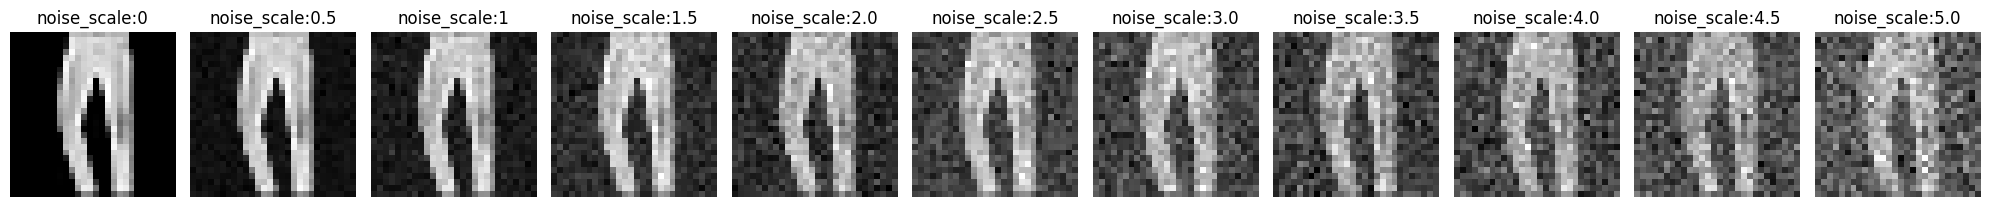

In [4]:
args = get_args.get_arg()
data_dir = './data/fashion'
sigma = 0.5
apply_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True, transform=apply_transform)
test_dataset = datasets.FashionMNIST(data_dir, train=False, download=True, transform=apply_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)
device = 'cuda'
global_model = models.capsule_argmax.CapsNet(device=device)
global_model.load_state_dict(torch.load(f'./checkpoints/Capsule/fashion/common_conv/best_model_fashion.pth'))
global_model.to(device)
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
ind = 5
input = images[ind].unsqueeze(0)
input.requires_grad = True
global_model.eval()
ground_truth_predictions, reconstruction, primary_caps_output, digit_caps_output, c, b= global_model(input)
_, predicted_classes = ground_truth_predictions.max(1)
ground_truth_prediction = torch.bincount(predicted_classes).argmax().item()
noise_scale = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0 ,3.5, 4.0, 4.5, 5.0]
show_image(input, noise_scale)

In [5]:
def test_capsule(model, device, test_loader):
    model.eval()
    correct, total = 0, 0
    for images, labels in test_loader:
        # Add channels = 1
        images = images.to(device)
        # Categogrical encoding
        labels = torch.eye(10).index_select(dim=0, index=labels).to(device)
        logits, reconstructions, primary_caps_output, digit_caps_output, c, b = model(images)
        pred_labels = torch.argmax(logits, dim=1)
        correct += torch.sum(pred_labels == torch.argmax(labels, dim=1)).item()
        total += len(labels)

    print('Accuracy: {}'.format(correct / total))

In [6]:
test_capsule(global_model, device, test_loader)
test_capsule(global_model, device, train_loader)

Accuracy: 0.9232
Accuracy: 0.9971333333333333


In [32]:
def visual_images2(model, index):
    input = images[index].unsqueeze(0)
    label = labels[index]
    input.requires_grad = True
    model.eval()
    ground_truth_predictions, reconstruction , primary_caps_output, digit_caps_output, c, b= model(input)
    _, predicted_class_index = torch.max(ground_truth_predictions, 1)
    print('--------------------')
    # print(f'The size of primary caps is {primary_caps_output.size()}')
    # print(f'The size of digit caps is {digit_caps_output.size()}')
    print('--------------------')
    print(f'The size of c is {c.size()}')
    print(f'The size of b is {b.size()}')
    print(f'c_max is {c[0][5]}')
    # print(f'c is {c}')
    return primary_caps_output, digit_caps_output, c, b

def visualize_digit_caps_output(digit_caps_output):
    caps_sizes = np.linalg.norm(digit_caps_output.squeeze().cpu().detach().numpy(), axis=1)
    plt.bar(range(len(caps_sizes)), caps_sizes)
    plt.xlabel('Capsule')
    plt.ylabel('Number of Votes')
    plt.title('Capsule Distribution')
    plt.show()

In [33]:
def visualize_digit_caps_output_smoothing_softmax(noise_scale, model, input, num_samples):
    image = images[input].unsqueeze(0)
    image_batch = image.repeat(num_samples, 1, 1, 1)
    noisy_images = add_gaussian_noise(noise_scale, image_batch)
    predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model(noisy_images)
    _, predicted_classes = predictions.max(1)
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    prediction = torch.bincount(predicted_classes).argmax().item()
    average_digit_caps_output = digit_caps_output.mean(dim=0, keepdim=True)
    c_int = torch.argmax(c, dim=1)
    c_int = c_int.view(-1)
    index_counts = torch.bincount(c_int, minlength=10)
    caps_sizes = index_counts / index_counts.sum()
    caps_sizes = caps_sizes.cpu().numpy()
    plt.bar(range(len(caps_sizes)), caps_sizes)
    plt.xlabel('Capsule')
    plt.ylabel('Number of Votes')
    plt.title('Capsule Distribution')
    plt.show()

In [34]:
def visualize_digit_caps_output_smoothing(noise_scale, model, input, num_samples):
    image = images[input].unsqueeze(0)
    image_batch = image.repeat(num_samples, 1, 1, 1)
    noisy_images = add_gaussian_noise(noise_scale, image_batch)
    predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model.argmax_forward(noisy_images)
    _, predicted_classes = predictions.max(1)
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    prediction = torch.bincount(predicted_classes).argmax().item()
    average_digit_caps_output = digit_caps_output.mean(dim=0, keepdim=True)
    # print(digit_caps_output)
    # print(average_digit_caps_output)
    # print(c)
    c_flat = c.view(-1)
    index_counts = torch.bincount(c_flat, minlength=10)
    caps_sizes = index_counts / index_counts.sum()
    caps_sizes = caps_sizes.cpu().numpy()
    # caps_sizes = np.linalg.norm(average_digit_caps_output.squeeze().cpu().detach().numpy(), axis=1)
    # print(caps_sizes)
    plt.bar(range(len(caps_sizes)), caps_sizes)
    plt.xlabel('Capsule')
    plt.ylabel('Number of Votes')
    plt.title('Capsule Distribution')
    plt.show()

In [35]:
index_new = 8 # 28 18 10 13 15 16 19 9 7 8

--------------------
--------------------
The size of c is torch.Size([1, 10, 1152, 1])
The size of b is torch.Size([1, 10, 1152, 1])
c_max is tensor([[0.0991],
        [0.1066],
        [0.1032],
        ...,
        [0.1043],
        [0.1032],
        [0.1206]], device='cuda:1')


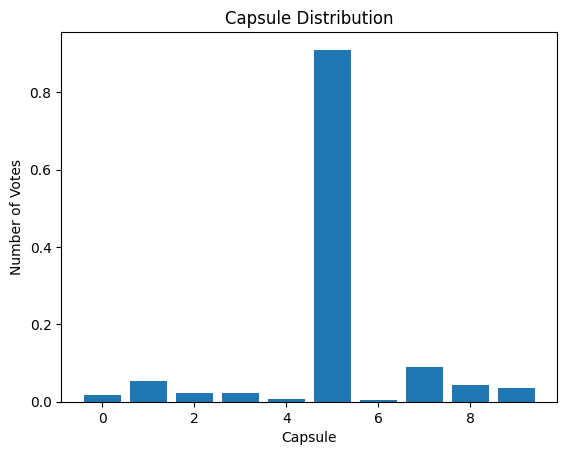

In [36]:
primary_caps_output_new, digit_caps_output_new, c_new, b_new = visual_images2(global_model, index_new)
visualize_digit_caps_output(digit_caps_output_new)

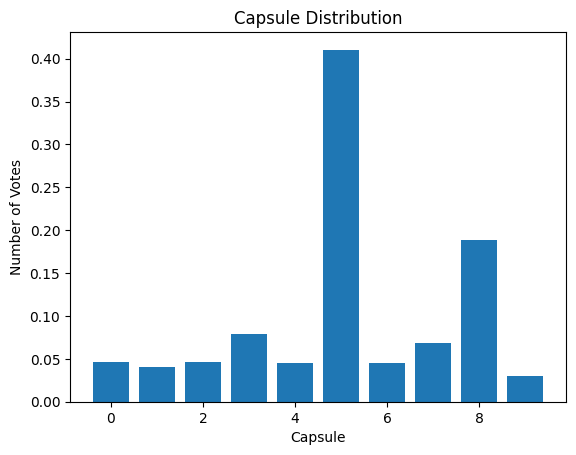

In [37]:
visualize_digit_caps_output_smoothing_softmax(0.5, global_model, index_new, 100)

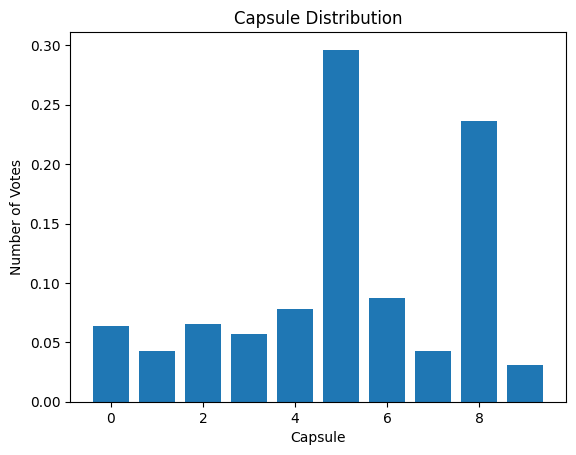

In [38]:
visualize_digit_caps_output_smoothing_softmax(1.0, global_model, index_new, 100)

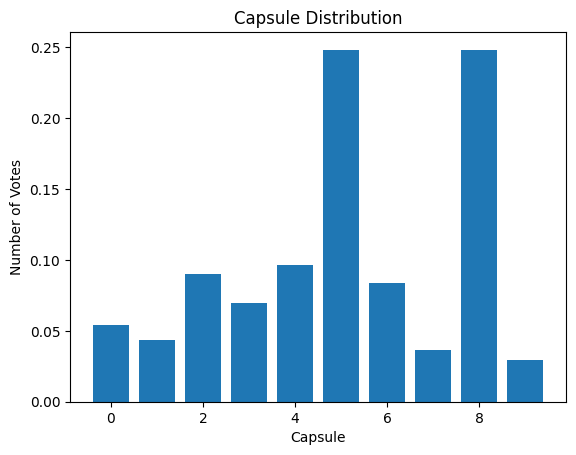

In [40]:
visualize_digit_caps_output_smoothing_softmax(1.5, global_model, index_new, 100)

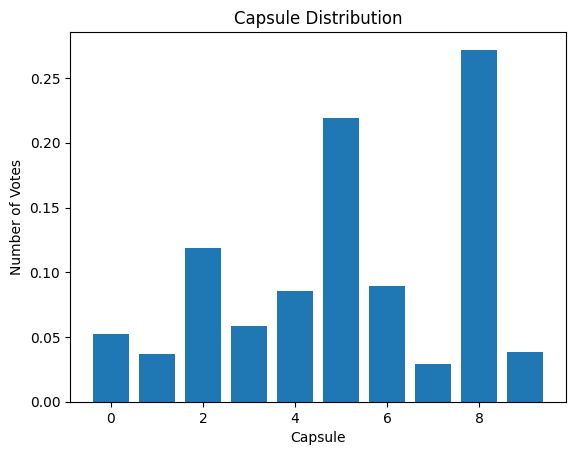

In [41]:
visualize_digit_caps_output_smoothing_softmax(2.0, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 1152, 1])


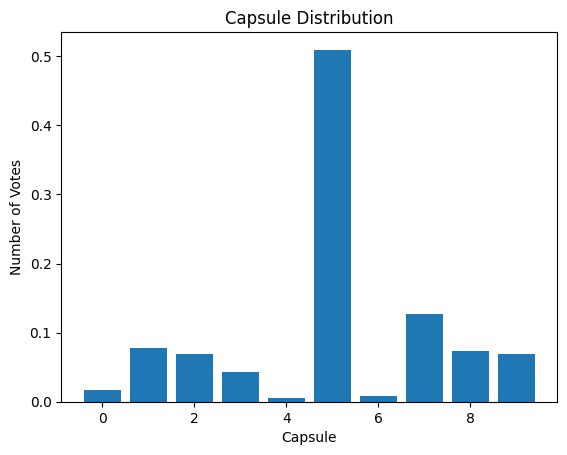

In [42]:
visualize_digit_caps_output_smoothing(0, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 1152, 1])


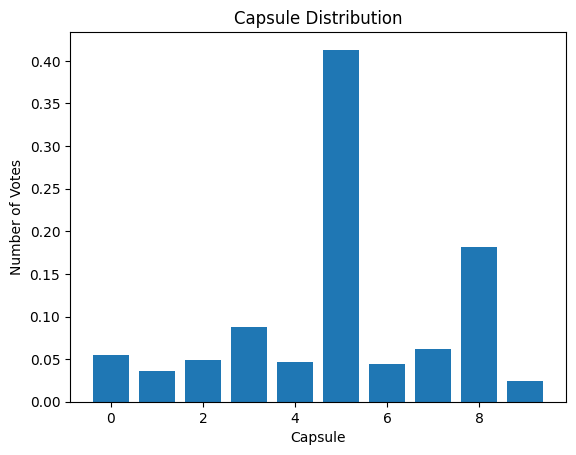

In [43]:
visualize_digit_caps_output_smoothing(0.5, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 1152, 1])


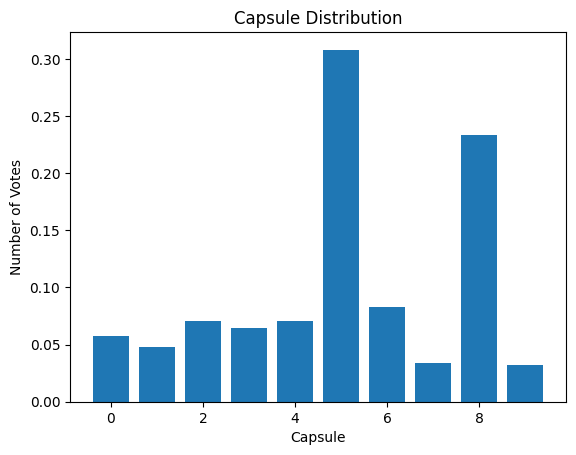

In [44]:
visualize_digit_caps_output_smoothing(1.0, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 1152, 1])


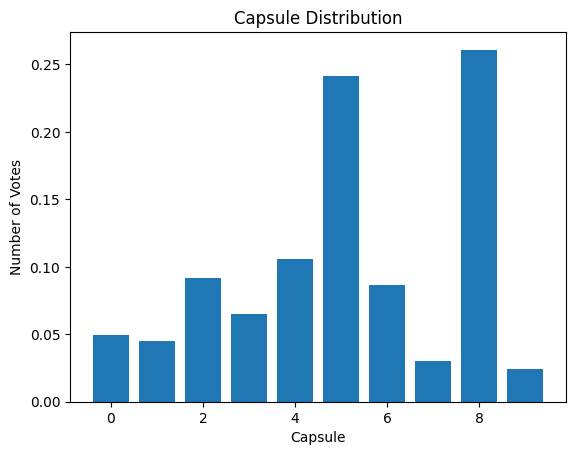

In [47]:
visualize_digit_caps_output_smoothing(1.5, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 1152, 1])


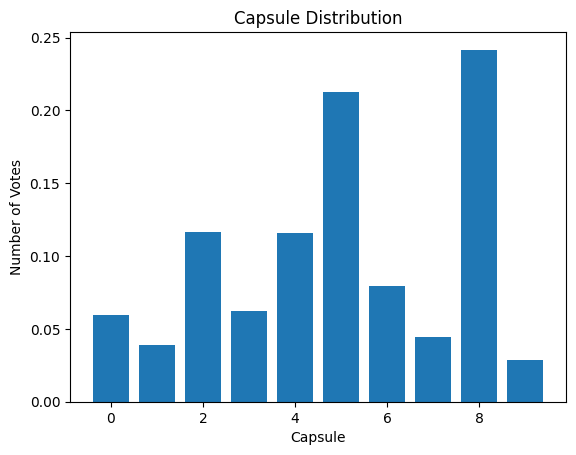

In [48]:
visualize_digit_caps_output_smoothing(2.0, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 1152, 1])


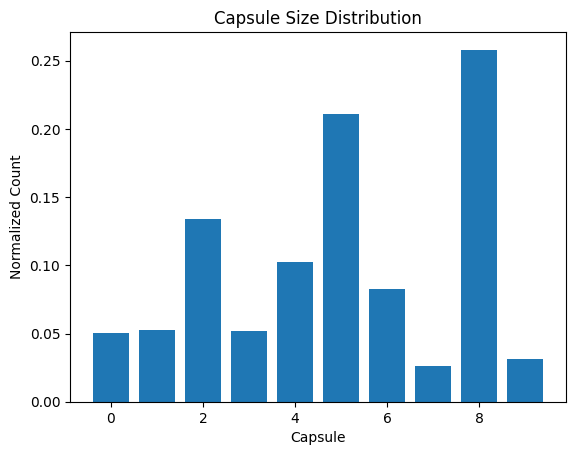

In [27]:
visualize_digit_caps_output_smoothing(3.0, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 1152, 1])


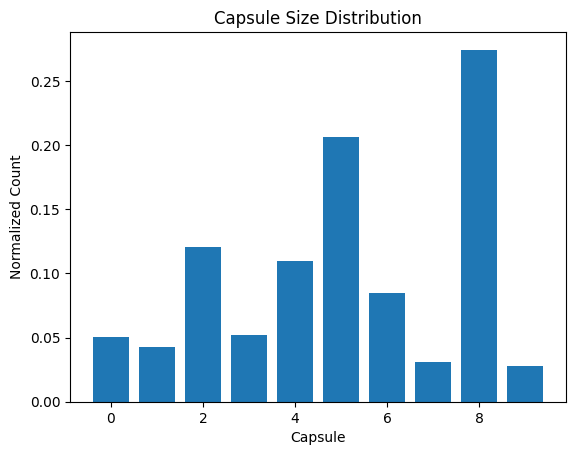

In [28]:
visualize_digit_caps_output_smoothing(2.5, global_model, index_new, 100)